In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

In [2]:
class CatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.annotation_paths = []

        for i in range(7):
            folder = os.path.join(root_dir, f'CAT_0{i}')
            for filename in os.listdir(folder):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(folder, filename)
                    annotation_path = image_path + '.cat'
                    if os.path.exists(annotation_path):
                        self.image_paths.append(image_path)
                        self.annotation_paths.append(annotation_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]

        image = Image.open(image_path).convert('RGB')
        original_size = image.size  

        if self.transform:
            image = self.transform(image)

        with open(annotation_path, 'r') as f:
            annotation = f.readline().strip().split()
            annotation = list(map(float, annotation[1:]))

        w_ratio = 224 / original_size[0]
        h_ratio = 224 / original_size[1]
        for i in range(0, len(annotation), 2):
            annotation[i] *= w_ratio
            annotation[i + 1] *= h_ratio

        annotation = torch.tensor(annotation)
        return image, annotation

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CatDataset(root_dir='/kaggle/input/cat-dataset', transform=transform)

In [4]:
resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
class ResNet50Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Backbone, self).__init__()
        resnet = resnet50(pretrained=pretrained)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        c1 = self.relu(self.bn1(self.conv1(x)))
        c2 = self.layer1(self.maxpool(c1))
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        return c3, c4, c5

In [6]:
import torch
import torch.nn as nn

class FPN(nn.Module):
    def __init__(self, backbone=ResNet50Backbone()):
        super(FPN, self).__init__()
        self.backbone = backbone
        
        self.lock()
        
        self.lateral3 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.lateral4 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.lateral5 = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        
        self.top_down4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.top_down3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def lock(self):
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unlock(self):
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        c3, c4, c5 = self.backbone(x)
        
        p5 = self.lateral5(c5)
        p4 = self.lateral4(c4) + self.upconv4(p5)
        p3 = self.lateral3(c3) + self.upconv3(p4)
        
        p4 = self.top_down4(p4)
        p3 = self.top_down3(p3)
        
        p3 = self.maxpool(p3)
        p4 = self.maxpool(p4)
        p5 = self.maxpool(p5)
        
        p3_flattened = torch.flatten(p3, start_dim=1)
        p4_flattened = torch.flatten(p4, start_dim=1)
        p5_flattened = torch.flatten(p5, start_dim=1)

        return p3_flattened, p4_flattened, p5_flattened


In [7]:
fpn = FPN()
for a in fpn(dataset[0][0].unsqueeze(dim=0)):
    print(a.shape)

torch.Size([1, 50176])
torch.Size([1, 12544])
torch.Size([1, 2304])


In [8]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        
        self.P3L1 = nn.Linear(50176, 4096)
        self.P3L2 = nn.Linear(4096, 2048)
        
        self.P4L1 = nn.Linear(12544, 4096)
        self.P4L2 = nn.Linear(4096, 2048)
        
        self.P5L1 = nn.Linear(2304, 4096)
        self.P5L2 = nn.Linear(4096, 2048)
        
        self.linear1 = nn.Linear(2048 * 3, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 18)
    
    def forward(self, p3_flattened, p4_flattened, p5_flattened):
        p3_out = F.relu(self.P3L1(p3_flattened))
        p3_out = F.relu(self.P3L2(p3_out))
        
        p4_out = F.relu(self.P4L1(p4_flattened))
        p4_out = F.relu(self.P4L2(p4_out))
        
        p5_out = F.relu(self.P5L1(p5_flattened))
        p5_out = F.relu(self.P5L2(p5_out))
        
        concatenated = torch.cat((p3_out, p4_out, p5_out), dim=1)
        
        x = F.relu(self.linear1(concatenated))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fpn = FPN()
        self.regressor = Regressor()
    
    def forward(self, image):
        p3_flattened, p4_flattened, p5_flattened = self.fpn(image)
        return self.regressor(p3_flattened, p4_flattened, p5_flattened)

In [10]:
def create_dataloaders(dataset, batch_size=32, train_split=0.8):
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader

In [11]:
def train_model(train_loader, val_loader, net, num_epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    net.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        if epoch == 2:
            net.fpn.unlock()
        for images, annotations in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images = images.to(device)
            annotations = annotations.to(device)
            
            optimizer.zero_grad()
            
            outputs = net(images)
            
            loss = criterion(outputs, annotations)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
        
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, annotations in val_loader:
                images = images.to(device)
                annotations = annotations.to(device)
                
                outputs = net(images)
                
                loss = criterion(outputs, annotations)
                val_loss += loss.item()
        
        print(f'Validation Loss: {val_loss/len(val_loader)}')

In [12]:
trainloader, valloader = create_dataloaders(dataset)

In [13]:
net = Net()

In [14]:
train_model(trainloader, valloader, net, num_epochs=20, learning_rate=3e-4)

Epoch 1/20: 100%|██████████| 250/250 [00:45<00:00,  5.48batch/s]

Epoch [1/20], Loss: 1978.9061489257813


Validation Loss: 372.2862546406095


Epoch 2/20: 100%|██████████| 250/250 [00:37<00:00,  6.69batch/s]

Epoch [2/20], Loss: 295.58849588012697


Validation Loss: 241.16940646701389


Epoch 3/20: 100%|██████████| 250/250 [00:49<00:00,  5.06batch/s]

Epoch [3/20], Loss: 184.8356361694336


Validation Loss: 177.8907267252604


Epoch 4/20: 100%|██████████| 250/250 [00:49<00:00,  5.05batch/s]

Epoch [4/20], Loss: 84.77791911315919


Validation Loss: 73.96144358317058


Epoch 5/20: 100%|██████████| 250/250 [00:49<00:00,  5.02batch/s]

Epoch [5/20], Loss: 47.28488439941406


Validation Loss: 58.086180641537624


Epoch 6/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [6/20], Loss: 32.93305564880371


Validation Loss: 44.57423679412357


Epoch 7/20: 100%|██████████| 250/250 [00:49<00:00,  5.02batch/s]

Epoch [7/20], Loss: 28.047694801330568


Validation Loss: 47.57723441956535


Epoch 8/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [8/20], Loss: 26.62814122390747


Validation Loss: 46.95526301671588


Epoch 9/20: 100%|██████████| 250/250 [00:49<00:00,  5.04batch/s]

Epoch [9/20], Loss: 24.93313243484497


Validation Loss: 38.615504052903916


Epoch 10/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [10/20], Loss: 22.797843132019043


Validation Loss: 45.30722875443716


Epoch 11/20: 100%|██████████| 250/250 [00:49<00:00,  5.02batch/s]

Epoch [11/20], Loss: 23.628959060668944


Validation Loss: 49.51667095365978


Epoch 12/20: 100%|██████████| 250/250 [00:49<00:00,  5.02batch/s]

Epoch [12/20], Loss: 53.20484838104248


Validation Loss: 191.97524091932507


Epoch 13/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [13/20], Loss: 105.97921217346192


Validation Loss: 83.4758169386122


Epoch 14/20: 100%|██████████| 250/250 [00:49<00:00,  5.04batch/s]

Epoch [14/20], Loss: 44.68416505432129


Validation Loss: 58.04464712597075


Epoch 15/20: 100%|██████████| 250/250 [00:49<00:00,  5.04batch/s]

Epoch [15/20], Loss: 28.015156761169433


Validation Loss: 48.106163267105345


Epoch 16/20: 100%|██████████| 250/250 [00:49<00:00,  5.04batch/s]

Epoch [16/20], Loss: 21.24121963119507


Validation Loss: 46.97960396418496


Epoch 17/20: 100%|██████████| 250/250 [00:49<00:00,  5.01batch/s]

Epoch [17/20], Loss: 18.131284015655517


Validation Loss: 44.195511303250754


Epoch 18/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [18/20], Loss: 18.138413009643553


Validation Loss: 48.442102523077104


Epoch 19/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [19/20], Loss: 17.077178203582765


Validation Loss: 46.49408119443863


Epoch 20/20: 100%|██████████| 250/250 [00:49<00:00,  5.03batch/s]

Epoch [20/20], Loss: 16.464874675750732


Validation Loss: 54.40120330689445


In [15]:
net = net.to('cpu')

In [26]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def denormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def plot_image_with_keypoints(image_tensor, keypoints):
    image = denormalize(image_tensor.clone())  
    
    image = image.permute(1, 2, 0).numpy()
    image = image.clip(0, 1)
    image = (image * 255).astype('uint8')

    plt.imshow(image)
    
    keypoints = keypoints.numpy()
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='red')
    
    plt.show()


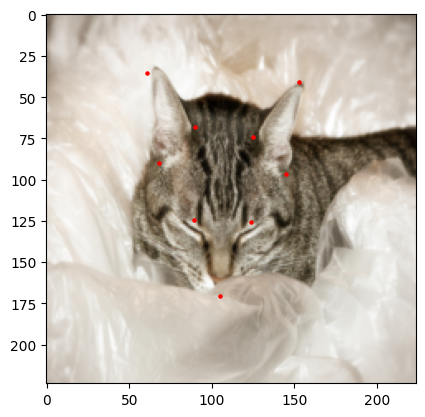

In [32]:
plot_image_with_keypoints(dataset[10][0], net(dataset[10][0].unsqueeze(dim=0))[0].view(-1, 2).detach())

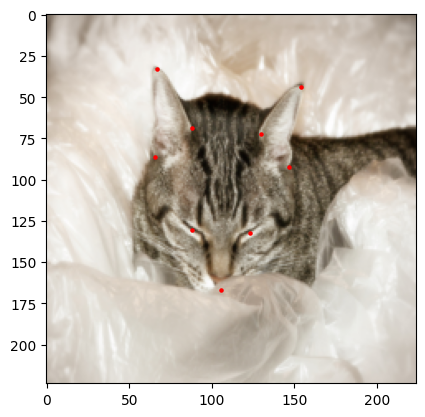

In [33]:
plot_image_with_keypoints(dataset[10][0], dataset[10][1].view(-1, 2))